# seismic rock physics

Rock Physics studies the relation between physical and elastic properties of rocks and is the basis of quantitative seismic interpretation.

It is one of the most fascinating subjects that has surfaced in recent years as it can be tackled at different scales of investigation, with various degrees of mathematical prowess, by people with varied backgrounds, from physicists to civil engineers, from mathematicians to petrophysicists as well as the odd geologist.

It has arguably given exploration geophysicists and AVO practitioners a solid quantitative basis to to substantiate, explain?, motivate? their interpretation of seismic data.

In this tutorial, I will offer a practical introduction to rock physics, showing how to code simple models and apply them to analyse well log data and their seismic response.

## input data loading

First let's load the data:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
#%config InlineBackend.figure_format = 'retina'

The well data used in this tutorial is part of the test datasets available on the Quantitative Seismic Interpretation book website:

https://srb.stanford.edu/quantitative-seismic-interpretation

In [2]:
L = pd.read_csv('qsiwell5.csv', index_col=0)

In [3]:
L.head()

,DT,DTS,GR,RHO,VP,VS,VPVS,IP,IS,VSH,RHOm,RHOf,PHIE
DEPTH,,,,,,,,,,,,,
2100.0720,127.134,312.372,86.778,2.262,2397.470386,975.759671,2.457030,5423.078012,2207.168376,0.484501,2.727520,1.09,0.284284
2100.2244,128.017,313.654,90.658,2.260,2380.933782,971.771442,2.450096,5380.910348,2196.203460,0.537838,2.736054,1.09,0.289209
2100.3767,128.512,313.706,102.479,2.267,2371.762948,971.610361,2.441064,5376.786604,2202.640689,0.700337,2.762054,1.09,0.296075
2100.5293,128.534,316.362,114.549,2.272,2371.356995,963.453259,2.461310,5387.723093,2188.965805,0.866259,2.788601,1.09,0.304133
2100.6816,128.309,321.356,118.948,2.275,2375.515357,948.480813,2.504548,5404.297438,2157.793849,0.926730,2.798277,1.09,0.306319


## data analysis

I will now define a function to plot a summary of all the data I need; I strongly suggest building the entire workflow as a series of modular, reusable functions. They will probably have a short lifespan and only be used within a specific project, but as I hope to show in the rest of this notebook, they will make the process easier to understand (for others) and remember (for us).

It is worth mentioning that it is straightforward to move all parameters that are only relevant for the particular case under analysis (e.g., chosen log curves, plot ranges, well markers) outside of the function and pass them as input parameters and therefore come up with a universal function reusable in other projects.

In this particular case, I will plot VSH (shale volume) and SW (water saturation) logs in the first track, then IP (acoustic impedance) in the second and VP/VS in the third track respectively; on these tracks I will highlight sands in yellow and shales in red, and I will also plot the top reservoir sands as a continuous line and the OWC (oil-water contact) as a dashed line. Next to these 3 tracks I will also crossplot PHIE (effective porosity) vs VP (P-wave velocity) and IP against VP/VS.

In the PHIE-VP crossplot I have decided to avoid plotting shales since effective porosity is effectively zero for pure shales so this plot will not help in the analysis of non-reservoir rocks.

In [4]:
# define basic styles for plotting log curves (sty0), sand (sty1) and shale (sty2)
sty0 = {'lw':1, 'color':'k', 'ls':'-'}
sty1 = {'marker':'o', 'color':'g', 'ls':'none', 'ms':6, 'mec':'none', 'alpha':0.5}
sty2 = {'marker':'o', 'color':'r', 'ls':'none', 'ms':6, 'mec':'none', 'alpha':0.5}

def plotlog(L, z1, z2, cutoff_sand, cutoff_shale): 
    # define filters to select sand (ss) and shale (sh)
    ss = (L.index>=z1) & (L.index<=z2) & (L.VSH<=cutoff_sand)
    sh = (L.index>=z1) & (L.index<=z2) & (L.VSH>=cutoff_shale)

    # plot figure    
    f = plt.subplots(figsize=(14, 6))
    ax0 = plt.subplot2grid((1,9), (0,0), colspan=1) # gr curve
    ax1 = plt.subplot2grid((1,9), (0,1), colspan=1) # ip curve
    ax2 = plt.subplot2grid((1,9), (0,2), colspan=1) # vp/vs curve
    ax3 = plt.subplot2grid((1,9), (0,3), colspan=3) # crossplot phi - vp
    ax4 = plt.subplot2grid((1,9), (0,6), colspan=3) # crossplot ip - vp/vs

    ax0.plot(L.VSH[ss], L.index[ss], **sty1)
    ax0.plot(L.VSH[sh], L.index[sh], **sty2)
    ax0.plot(L.VSH, L.index, **sty0)
    ax0.set_xlabel('VSH')
    ax0.locator_params(axis='x', nbins=2)

    ax1.plot(L.IP[ss], L.index[ss], **sty1)
    ax1.plot(L.IP[sh], L.index[sh], **sty2)
    ax1.plot(L.IP, L.index,  **sty0)
    ax1.set_xlabel('$I_\mathrm{P}$')
    ax1.set_xlim(4e3,8e3)
    ax1.locator_params(axis='x', nbins=2)

    ax2.plot(L.VPVS[ss], L.index[ss], **sty1)
    ax2.plot(L.VPVS[sh], L.index[sh], **sty2)
    ax2.plot(L.VPVS, L.index, **sty0)
    ax2.set_xlabel('$V_\mathrm{P}/V_\mathrm{S}$')
    ax2.set_xlim(1.5,3)
    ax2.locator_params(axis='x', nbins=2)

    ax3.plot(L.PHIE[ss], L.VP[ss], **sty1)
    ax3.set_xlim(0,0.4),  ax3.set_ylim(2e3,4e3)
    ax3.set_xlabel('$V_\mathrm{P}$ vs $\phi_\mathrm{e}$')

    ax4.plot(L.VP*L.RHO[ss], L.VP/L.VS[ss], **sty1)
    ax4.plot(L.VP*L.RHO[sh], L.VP/L.VS[sh], **sty2)
    ax4.set_xlim(4e3,8e3),  ax4.set_ylim(1.5,3)
    ax4.set_xlabel('$V_\mathrm{P}/V_\mathrm{S}$ vs $I_\mathrm{P}$')

    for aa in [ax0,ax1,ax2]:
        aa.set_ylim(z2,z1)
#         aa.axhline(2153, color='k', ls='-')
#         aa.axhline(2183, color='k', ls='--')
    for aa in [ax0,ax1,ax2,ax3,ax4]:
        aa.tick_params(which='major', labelsize=8)
    for aa in [ax1,ax2]:
        aa.set_yticklabels([])
    plt.subplots_adjust(wspace=.8,left=0.05,right=0.95)
    
    #plt.savefig('/Users/matt/Dropbox/Agile/SEG/Tutorials/delMonte_Apr2017/Figure_1.png', dpi=300)
    plt.show()

Let's plot the data between 2100 and 2300m:

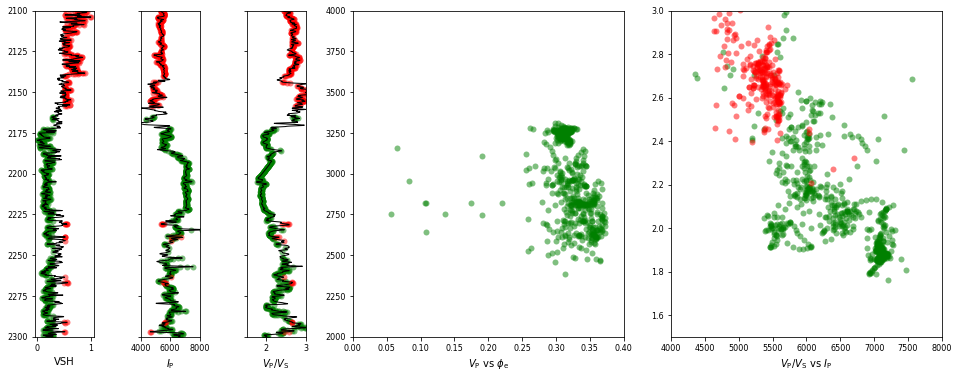

In [5]:
plotlog(L, 2100, 2300, 0.3, 0.5)

<!--What this plot shows is that there are two sand sections, a shallower one between 2040 and 2075m and another below 2150m, separated by a thick shale package. We see on the PHI-VP crossplot two distinct clusters, and it is very likely that they represent the two sands; to prove it we do the plot again but this time taking only the lower interval into consideration:-->

We can restrict the analysis to a slightly shorter window to avoid the inclusion of what seems to be a very silty interval just below 2250m:

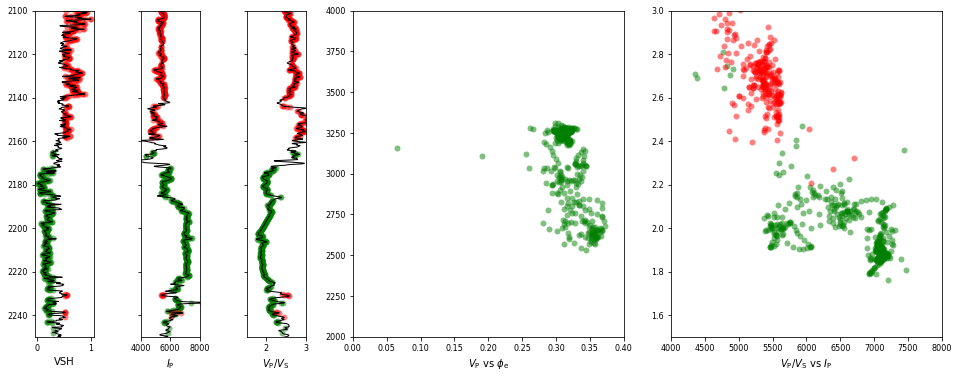

In [6]:
plotlog(L, 2100, 2250, 0.3, 0.5)

We will concentrate on the lower interval where, in a nutshell, we have a high Vp/Vs, low impedance shale and a high porosity, low Vp/Vs and high impedance sand.

# rock physics modeling


All rock physics models output dry-rock frame moduli:  $K_d$ (bulk modulus) and $\mu_d$ (shear modulus). These moduli represent the resistance of the rock's dry frame to normal and tangential stresses. They are used together with Gassmann's equation to calculate the saturated rock moduli ($K$ and $\mu$) which are, together with densities, the building blocks for the P-wave and S-wave velocities ($V_p$ and $V_s$):

$$V_p = \sqrt{\frac{k+4/3\mu}{\rho}}$$
$$V_s = \sqrt{\frac\mu{\rho}}$$

The product of velocity by density is called impedance, and impedance contrasts are ultimately what generate seismic data; this is why rock physics, by linking rock and fluid properties to velocities, allows us to understand and explain seismic reflections.

I will introduce here two simple but useful models, the Soft Sand and the Stiff Sand model.  Both models have the high porosity endpoint calculated via the Hertz-Mindlin theory, which is then connected to the zero porosity endpoint via respectively the lower or the upper Hashin-Shtrikman bounds. Details on Hertz-Mindlin, Hashin-Shtrikman and Gassmann's equations can be found in the referenced literature at the end of the notebook and will not be repeated here; the inputs however are worth spending a few more words on.

Let's see the equation for the high porosity endpoint for both models, which is calculated via the Hertz-Mindlin's equation:

$$ K_d = \frac{ P C_n^2 (1-\phi_c)^2 \mu_0^2} {18 \pi^2 (1-\sigma_0)^2}^{(1/3)} $$

The input variables are therefore the effective pressure ($P$), the coordination number ($C_n$), i.e the average number of contacts that each grain has with surrounding grains, the critical porosity ($\phi_c$), i.e. the porosity of a siliciclastic sediment at initial deposition, and the mineral shear modulus $\mu_0$ and Poisson's ratio ($\sigma_0$).

<!--Gassmann's equations are used to mix dry-rock and fluid moduli to output the saturated rock moduli:

$$ K_s = K_d + \frac { (1-\frac{K_d}{K_0})^2} { \frac{\phi}{K_f} + \frac{1-\phi}{K_0} - \frac{K_d}{K_0^2}}$$

$$\mu_s = \mu_d$$-->

It is admittedly very confusing (and a bit intimidating) the distinction between dry-rock, saturated and mineral moduli, but it is however very important to make that distinction and understand the differences between them.

In simple words, rocks are made of a mixture of minerals and fluids. All the mineral components have an inherent resistance to compressional and shear stresses, which we call bulk and shear mineral moduli ($K0$ and $\mu0$). The fluids offer a certain resistance to compressional stresses but not to shear stresses, and thus we only have bulk fluid moduli ($K_f$) to deal with.

The dry-rock concept is a basic concept that is very often a source of confusion for those approaching the subject for the first time. It represents the overall structure of a rock, i.e., the way solid portions and empty spaces within a rock are arranged relative to each other; I think _architecture_ gives a better idea of the dry-rock frame concept.

The differences between a 'soft' rock like the red friable sandstones that form the big arches in the USA's eponym national park and a 'stiff' rock like the limestones bounding the beautiful beaches with sheer cliffs along the southern Italian coast are not only due to their mineralogical components but also to their internal architecture.


***

I will define now the following functions:

* `vrh`: to calculate average properties for mixture of 2 minerals or fluids
* `hertzmindlin`: to calculate the high porosity endpoints
* `softsand`: to calculate dry-rock moduli using the Soft Sand model
* `stiffsand`: to calculate dry-rock moduli using the Stiff Sand model
* `vels`: to calculate saturated moduli and velocities

In [7]:
def vrh(f, M1, M2):
    '''
    Simple Voigt-Reuss-Hill bounds for 2-components mixture, (C) aadm 2017

    INPUT
    f: volumetric fraction of mineral 1
    M1: elastic modulus mineral 1
    M2: elastic modulus mineral 2

    OUTPUT
    M_Voigt: upper bound or Voigt average
    M_Reuss: lower bound or Reuss average
    M_VRH: Voigt-Reuss-Hill average
    '''
    M_Voigt = f*M1 + (1-f)*M2
    M_Reuss = 1/ ( f/M1 + (1-f)/M2 )
    M_VRH   = (M_Voigt+M_Reuss)/2
    return M_Voigt, M_Reuss, M_VRH

In [8]:
def vels(K_DRY, G_DRY, K0, D0, Kf, Df, phi):
    '''
    Calculates velocities and densities of saturated rock via Gassmann equation, (C) aadm 2015

    INPUT
    K_DRY,G_DRY: dry rock bulk & shear modulus in GPa
    K0, D0: mineral bulk modulus and density in GPa
    Kf, Df: fluid bulk modulus and density in GPa
    phi: porosity
    '''
    rho  = D0*(1-phi)+Df*phi
    K    = K_DRY + (1-K_DRY/K0)**2 / ( (phi/Kf) + ((1-phi)/K0) - (K_DRY/K0**2) )
    vp   = np.sqrt((K+4./3*G_DRY)/rho)*1e3
    vs   = np.sqrt(G_DRY/rho)*1e3
    return vp, vs, rho, K

In [9]:
def hertzmindlin(K0, G0, phi, phic=0.4, Cn=8.6, P=10, f=1):
    '''
    Hertz-Mindlin model
    written by aadm (2015) from Rock Physics Handbook, p.246

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    P: confining pressure in MPa (default 10)
    f: shear modulus correction factor
       1=dry pack with perfect adhesion
       0=dry frictionless pack
    '''
    P   /= 1e3 # converts pressure in same units as solid moduli (GPa)
    PR0  =(3*K0-2*G0)/(6*K0+2*G0) # poisson's ratio of mineral mixture
    K_HM = (P*(Cn**2*(1-phic)**2*G0**2) / (18*np.pi**2*(1-PR0)**2))**(1/3)
    G_HM = ((2+3*f-PR0*(1+3*f))/(5*(2-PR0))) * ((P*(3*Cn**2*(1-phic)**2*G0**2)/(2*np.pi**2*(1-PR0)**2)))**(1/3)
    return K_HM, G_HM

In [10]:
def softsand(K0, G0, phi, phic=0.4, Cn=8.6, P=10, f=1):
    '''
    Soft-sand (uncemented) model
    written by aadm (2015) from Rock Physics Handbook, p.258

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    P: confining pressure in MPa (default 10)
    f: shear modulus correction factor
       1=dry pack with perfect adhesion
       0=dry frictionless pack
    '''
    K_HM, G_HM = hertzmindlin(K0, G0, phi, phic, Cn, P, f)
    K_DRY =-4/3*G_HM + (((phi/phic)/(K_HM+4/3*G_HM)) + ((1-phi/phic)/(K0+4/3*G_HM)))**-1
    tmp   = G_HM/6*((9*K_HM+8*G_HM) / (K_HM+2*G_HM))
    G_DRY = -tmp + ((phi/phic)/(G_HM+tmp) + ((1-phi/phic)/(G0+tmp)))**-1
    return K_DRY, G_DRY

In [11]:
def stiffsand(K0, G0, phi, phic=0.4, Cn=8.6, P=10, f=1):
    '''
    Stiff-sand model
    written by aadm (2015) from Rock Physics Handbook, p.260

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    P: confining pressure in MPa (default 10)
    f: shear modulus correction factor
       1=dry pack with perfect adhesion
       0=dry frictionless pack
    '''
    K_HM, G_HM = hertzmindlin(K0, G0, phi, phic, Cn, P, f)
    K_DRY  = -4/3*G0 + (((phi/phic)/(K_HM+4/3*G0)) + ((1-phi/phic)/(K0+4/3*G0)))**-1
    tmp    = G0/6*((9*K0+8*G0) / (K0+2*G0))
    G_DRY  = -tmp + ((phi/phic)/(G_HM+tmp) + ((1-phi/phic)/(G0+tmp)))**-1
    return K_DRY, G_DRY

Let's set some starting parameters for minerals and fluids:

* `RHO_qz`, `K_qz`, `MU_qz` are density, bulk and shear moduli for quartz
* `RHO_sh`, `K_sh`, `MU_sh` are density, bulk and shear moduli for a generic shale mineral
* `RHO_b`, `K_b`, `RHO_o`, `K_o`, `RHO_g`, `K_g` are density and bulk modulus for brine, oil and gas

A few additional parameters required by the rock physics equations are:

* `Cn` is the coordination number
* `phic` is the critical porosity
* `f` is the shear modulus correction factor (`f=1` for dry pack with perfect adhesion between particles and `f=0` for a dry frictionless pack)

Finally, `phi` is a vector of porosity values which is the most important parameter for all these models.

In [12]:
RHO_qz = 2.6;   K_qz = 37;  MU_qz = 44
RHO_sh = 2.8;   K_sh = 15;  MU_sh = 5
RHO_b = 1.1 ;   K_b = 2.8 
RHO_o = 0.8;    K_o = 0.9
RHO_g = 0.2;    K_g = 0.06              

Cn = 8
phic = 0.4
f = 1

phi=np.linspace(0.01, 0.4)

As a starting point, I will assume that the reservoir sands are 'clean' (i.e., entirely made of quartz) so the mineral moduli are the same as the quartz moduli; I will also calculate the velocities for both the Soft and the Stiff Sand models using brine as saturating fluid:

In [13]:
K0, MU0, RHO0 = K_qz, MU_qz, RHO_qz

Kdry, MUdry = softsand(K0, MU0, phi, phic, Cn, P=45)
vp_ssm, vs_ssm, rho_ssm, _ = vels(Kdry, MUdry, K0, RHO0, K_b, RHO_b, phi)

Kdry, MUdry = stiffsand(K0, MU0, phi, phic, Cn, P=45)
vp_sti, vs_sti, rho_sti, _ = vels(Kdry, MUdry, K0, RHO0, K_b, RHO_b, phi)

I will plot the same data as before (i.e., the reservoir sand from 2150m to 2200m) in the PHI-VP crossplot, superimposing the Soft Sand (continuous black line) and the Stiff Sand (dotted line) model lines:

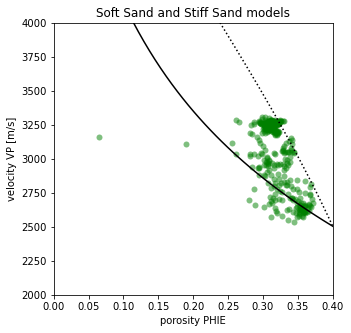

In [14]:
z1, z2, cutoff_sand, cutoff_shale = 2100, 2250, 0.3, 0.5

ss = (L.index >= z1) & (L.index <= z2) & (L.VSH <= cutoff_sand)
sh = (L.index >= z1) & (L.index <= z2) & (L.VSH >= cutoff_shale)

f, ax = plt.subplots(figsize=(5, 5))
ax.plot(L.PHIE[ss], L.VP[ss], **sty1)
ax.plot(phi, vp_ssm, '-k')
ax.plot(phi, vp_sti, ':k')
ax.set_xlim(0,0.4),  ax.set_ylim(2e3,4e3)
ax.set_xlabel('porosity PHIE')
ax.set_ylabel('velocity VP [m/s]')
ax.set_title('Soft Sand and Stiff Sand models')

#plt.savefig('/Users/matt/Dropbox/Agile/SEG/Tutorials/delMonte_Apr2017/Figure_2_part1.png', dpi=300)
plt.show()

At a first sight, both models may offer a good starting point to investigate these sands. 

The sands in this section are not hydrocarbon-bearing so I can dismiss fluid effects and start leveraging the rock physics model by displaying how mineralogy affects the velocities. To do that, I will simplify the problem assuming variations in Net:Gross. When N:G is 1, then the mineral moduli will be equal to those of quartz, when N:G is lower than 1 than I will use composite mineral moduli given by the Voigt-Reuss-Hill average of quartz and a generic shale:

$$K_{Voigt} = (V_{qz} \cdot K_{qz}) + (V_{sh} \cdot K_{sh}) $$

$$K_{Reuss} = \frac{1} { (V_{qz} / K_{qz}) + (V_{sh} / K_{sh}) } $$

$$K_{Hill} = \frac{K_{Voigt} + K_{Reuss} } {2}  $$

In other words, if N:G=0.8 and the quartz and shale mineral moduli are respectively $K_{qz}=37$, $K_{sh}=15$ and $\mu_{qz}=44$ and $\mu_{sh}=5$:

In [15]:
K_Voigt = 0.8*K_qz + 0.2*K_sh
K_Reuss = 1/ ( 0.8/K_qz + 0.2/K_sh )
K_Hill = (K_Voigt + K_Reuss) / 2

MU_Voigt = 0.8*MU_qz + 0.2*MU_sh
MU_Reuss = 1/ ( 0.8/MU_qz + 0.2/MU_sh )
MU_Hill = (MU_Voigt + MU_Reuss) / 2

print('K_VRH = {:.2f}, mu_VRH = {:.2f}'.format(K_Hill, MU_Hill))

K_VRH = 30.60, mu_VRH = 26.69


Density of the composite mineral are easier to calculate:

$$ \rho = V_{qz} \cdot \rho_{qz} + V_{sh} \cdot \rho_{sh} $$

therefore:

In [16]:
rho = 0.8*RHO_qz + 0.2*RHO_sh

print('RHO = {:.2f}'.format(rho))

RHO = 2.64


Now let's put it all together and create show how the models change for different mineralogies:

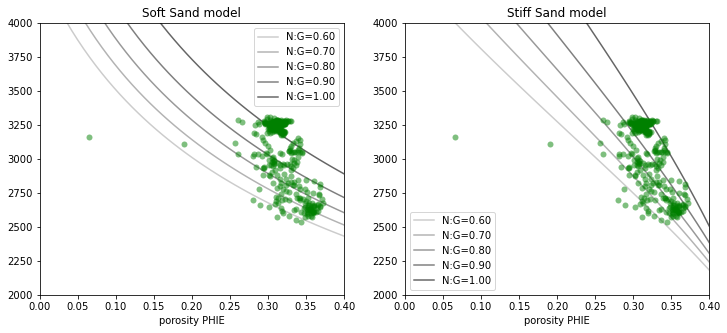

In [17]:
NG=np.linspace(0.6, 1.0, 5)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

for i in NG:
    _,_,K0 = vrh(i,K_qz,K_sh)
    _,_,MU0 = vrh(i,MU_qz,MU_sh)    
    RHO0 = i*RHO_qz+(1-i)*RHO_sh
    Kdry, MUdry = softsand(K0, MU0, phi, phic=.5, Cn=12, P=45)
    vp_ssm,vs_ssm,rho_ssm,_= vels(Kdry,MUdry,K0,RHO0,K_b,RHO_b,phi)
    Kdry, MUdry = stiffsand(K0, MU0, phi, phic=.4, Cn=8, P=45)
    vp_sti,vs_sti,rho_sti,_= vels(Kdry,MUdry,K0,RHO0,K_b,RHO_b,phi)
    ax[0].plot(phi, vp_ssm, '-k', label='N:G={:.2f}'.format(i),alpha=i-.4)
    ax[1].plot(phi, vp_sti, '-k', label='N:G={:.2f}'.format(i),alpha=i-.4)

for aa in ax:
    aa.plot(L.PHIE[ss], L.VP[ss], **sty1, label='')
    aa.set_xlim(0, 0.4), aa.set_ylim(2e3, 4e3)
    aa.legend(loc='best')

ax[0].set_title('Soft Sand model')
ax[0].set_xlabel('porosity PHIE')

ax[1].set_title('Stiff Sand model')
ax[1].set_xlabel('porosity PHIE')

# plt.savefig('/Users/matt/Dropbox/Agile/SEG/Tutorials/delMonte_Apr2017/Figure_2_part2.png', dpi=300)
plt.show()

To have the models spread out to cover the entire range of the well data, I had to code them with different parameters. In the code cell above, these are the lines that call the two models:

    Kdry, MUdry = softsand(K0, MU0, phi, phic=.5, Cn=12, P=45)
    Kdry, MUdry = stiffsand(K0, MU0, phi, phic=.4, Cn=8, P=45)

The Soft Sand model uses higher critical porosity and coordination number than the Stiff Sand model, which means that the reservoir sands can be described by either a stiffer 'soft' sand or a 'softer' stiff sand (the coordination number `Cn` suggests a closer packing of the individual grains that make up our sand, which in turn means a more compact and harder material).

If a more accurate petrophysical analysis was available, it would make sense to color-code the well data to the various mineralogical volumes and try also to deduce the mineral assemblage. In this case however the shale volume was created from the gamma ray log and within the reservoir sand it would give us very little insight into the actual mineralogy of the sand. Therefore it is up to the interpreter to decide if the spread of the rock physics models could help in determining the reason behind the scatter of the data, since as already pointed out it is not due to fluid variations.

So far then, both models fit the datapoints. It is up to the interpreter to decide which model is more appropriate; this is an essential question and it has probably more to do with the expectations we have than other hard data. The behaviour of the model lines with decreasing varying porosity is particularly important; do we expect to have very abrupt increases in velocity for a single porosity unit increase like in the Stiff Sand model? Does this fit with the knowledge we have from nearby wells or formation analogues?

In [18]:
phi_test = np.array([0.2,0.3])

Kdry, MUdry = softsand(K0, MU0, phi_test, phic=.5, Cn=12, P=45)
vp_ssm,_,_,_= vels(Kdry,MUdry,K0,RHO0,K_b,RHO_b,phi_test)

Kdry, MUdry = stiffsand(K0, MU0, phi_test, phic=.4, Cn=8, P=45)
vp_sti,_,_,_ = vels(Kdry,MUdry,K0,RHO0,K_b,RHO_b,phi_test)

print('Soft Sand RPM: phi={:.2f} --> Vp={:.0f} m/s'.format(phi_test[0],vp_ssm[0]))
print('Soft Sand RPM: phi={:.2f} --> Vp={:.0f} m/s'.format(phi_test[1],vp_ssm[1]))
print('Soft Sand RPM: increase in Vp after 10% porosity decrease={:.0%}'.format((vp_ssm[0]-vp_ssm[1])/vp_ssm[1]))

print('Stiff Sand RPM: phi={:.2f} --> Vp={:.0f} m/s'.format(phi_test[0],vp_sti[0]))
print('Stiff Sand RPM: phi={:.2f} --> Vp={:.0f} m/s'.format(phi_test[1],vp_sti[1]))
print('Stiff Sand RPM: increase in Vp after 10% porosity decrease={:.0%}'.format((vp_sti[0]-vp_sti[1])/vp_sti[1]))

Soft Sand RPM: phi=0.20 --> Vp=3733 m/s
Soft Sand RPM: phi=0.30 --> Vp=3245 m/s
Soft Sand RPM: increase in Vp after 10% porosity decrease=15%
Stiff Sand RPM: phi=0.20 --> Vp=4320 m/s
Stiff Sand RPM: phi=0.30 --> Vp=3477 m/s
Stiff Sand RPM: increase in Vp after 10% porosity decrease=24%


Is it reasonable to assume that velocities would increase so much (from 3477 to 4320 m/s) when the reservoir goes from good to only slighty less than good porosities? In the absence of a good geological background, an investigation on other wells that have penetrated similar lithologies would probably point us in the right direction.

## rock physics templates

The set of models for varying degrees of N:G shown above are a basic example of rock physics templates (RPTs). It is fairly easy to build from that and have a function to create RPTs which show not only variations in porosity and mineralogy but also fluid content.

Avseth first introduced the concept of _rock physics templates_ (RPT) to display a reference framework of all the possible variations of a particular rock and use such templates to understand actual well log data (or seismic-derived elastic properties).

In the code cell below, I have simply assembled the functions to compute $K_{dry}$ and $\mu_{dry}$ for the two models (Soft and Stiff Sand), the velocities using Gassmann's equation therefore giving the user to select which kind of fluid variations to analyse (from brine to oil or brine to gas), and return arrays of IP and VP/VS that we can overlay on top of well data. In addition to that, the function will also plot the actual RPTs with all the labels to make sense of it.

In [19]:
def rpt(model='soft',vsh=0.0,fluid='gas',phic=0.4,Cn=8,P=10,f=1,display=True):
    phi=np.linspace(0.01,phic,10)
    sw=np.linspace(0,1,10)
    xx=np.empty((phi.size,sw.size))
    yy=np.empty((phi.size,sw.size))
    (K_hc, RHO_hc) = (K_g, RHO_g) if fluid == 'gas' else (K_o, RHO_o)

    _,_,K0 = vrh(vsh,K_sh,K_qz)
    _,_,MU0 = vrh(vsh,MU_sh,MU_qz)
    RHO0 = vsh*RHO_sh+(1-vsh)*RHO_qz
    if model=='soft':
        Kdry, MUdry = softsand(K0,MU0,phi,phic,Cn,P,f)
    elif model=='stiff':
        Kdry, MUdry = stiffsand(K0,MU0,phi,phic,Cn,P,f)

    for i,val in enumerate(sw):
        _,K_f,_= vrh(val,K_b,K_hc)
        RHO_f = val*RHO_b + (1-val)*RHO_hc
        vp,vs,rho,_= vels(Kdry,MUdry,K0,RHO0,K_f,RHO_f,phi)
        xx[:,i]=vp*rho
        yy[:,i]=vp/vs
    opt1={'backgroundcolor':'0.9'}
    opt2={'ha':'right','backgroundcolor':'0.9'}
    
    if display:
        plt.figure(figsize=(7,7))
        plt.plot(xx, yy, '-ok', alpha=0.3)
        plt.plot(xx.T, yy.T, '-ok', alpha=0.3)
        for i,val in enumerate(phi):
            plt.text(xx[i,-1]+150,yy[i,-1]+.02,'$\phi={:.02f}$'.format(val), **opt1)
        plt.text(xx[-1,0]-200,yy[-1,0]-0.015,'$S_\mathrm{{w}}={:.02f}$'.format(sw[0]), **opt2)
        plt.text(xx[-1,-1]-200,yy[-1,-1]-0.015,'$S_\mathrm{{w}}={:.02f}$'.format(sw[-1]), **opt2)
        plt.xlabel('IP'), plt.ylabel('VP/VS')
        plt.xlim(2e3,11e3)
        plt.ylim(1.6,2.8)

        #plt.title('RPT {} (N:G={}, fluid={})'.format(model.upper(),1-vsh, fluid))
        
        # plt.savefig('/Users/matt/Dropbox/Agile/SEG/Tutorials/delMonte_Apr2017/Figure_3_part1.png', dpi=300)
        plt.show()
    return xx,yy

Let's try the function `rpt` to show the templates for both Soft and Stiff Sand models in the IP/VPVS domain. The parameters passed to the function are those that I have previously selected in my initial assessment (but once we go from the PHI/VP to IP/VPVS domain it is likely that these parameters will be fine-tuned).

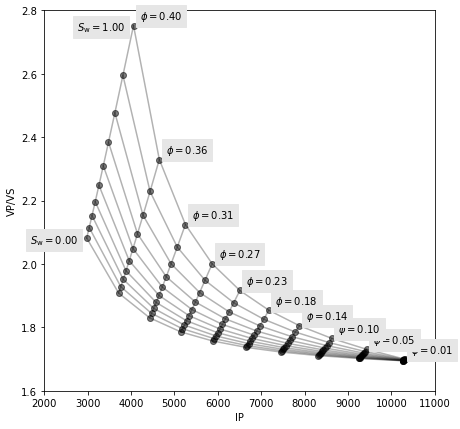

In [20]:
ip_rpt1, vpvs_rpt1 = rpt(model='stiff',vsh=0.6,fluid='oil',phic=0.4,Cn=8,P=45,f=.3)

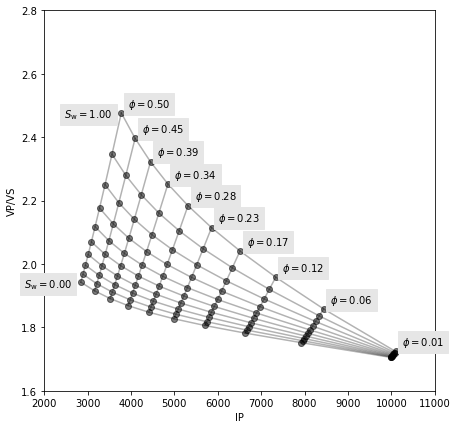

In [21]:
ip_rpt0, vpvs_rpt0 = rpt(model='soft',vsh=0.6,fluid='oil',phic=0.5,Cn=12,P=45,f=.3)

Now let's plot them together with the well data:

In [22]:
# f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
# ax[0].plot(ip_rpt0, vpvs_rpt0, 'sk', mew=0, alpha=0.5)
# ax[1].plot(ip_rpt1, vpvs_rpt1, 'sk', mew=0, alpha=0.5)
# for aa in ax:
#     aa.plot(L.VP[ss]*L.RHO[ss], L.VP[ss]/L.VS[ss], **sty1)
#     aa.set_xlim(2e3,10e3), aa.set_ylim(1.6,2.8)
# ax[0].set_title('Soft Sand RPM')
# ax[1].set_title('Stiff Sand RPM')

# ax[0].set_xlabel('IP')
# ax[0].set_ylabel('VP/VS')

# plt.savefig('/Users/matt/Dropbox/Agile/SEG/Tutorials/delMonte_Apr2017/Figure_3_part2.png', dpi=300)
# plt.show()

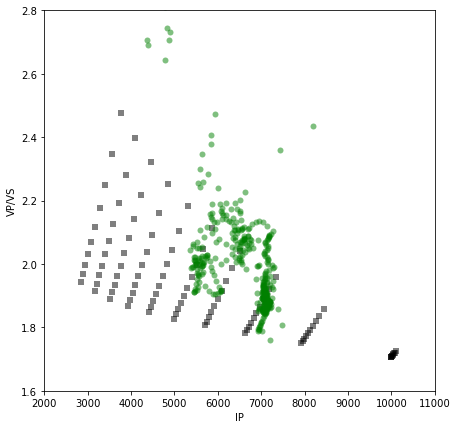

In [23]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax.plot(ip_rpt0, vpvs_rpt0, 'sk', mew=0, alpha=0.5)
ax.plot(L.VP[ss]*L.RHO[ss], L.VP[ss]/L.VS[ss], **sty1)
ax.set_xlim(2e3,11e3)
ax.set_ylim(1.6,2.8)

ax.set_xlabel('IP')
ax.set_ylabel('VP/VS')

# plt.savefig('/Users/matt/Dropbox/Agile/SEG/Tutorials/delMonte_Apr2017/Figure_3_part2.png', dpi=300)
plt.show()

By choosing a full elastic domain to display the data, the Soft Sand RPM starts to make more sense, as it shows more gradual variations when porosity or fluid changes, in tune with the experimental data.

An additional parameter that I had to set to fit the well data is the shear modulus correction factor `f` which most of the times becomes a pure fitting parameter, as it has very little correlation with any other piece of information that is usually available in exploration geophysics.

***

This game can be played forever, for example one can check the validity of the elastic moduli assigned to the second mineral (the one I have referred to as "shale") by computing and displaying different RPTs (in the plot below, the RPT for a 'clean' sand is in black, and red is the RPT for a shaly sand):

(1.6, 2.8)

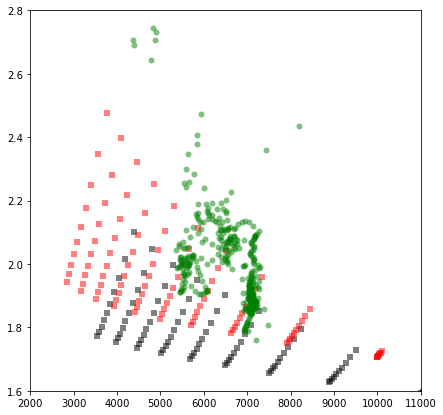

In [24]:
# Original parameters.
RHO_sh=2.8;   K_sh=15;  MU_sh=5

ip_rpt0a, vpvs_rpt0a = rpt(model='soft',vsh=0.0,fluid='oil',phic=0.5,Cn=12,P=45,f=.3,display=False)
ip_rpt0b, vpvs_rpt0b = rpt(model='soft',vsh=0.6,fluid='oil',phic=0.5,Cn=12,P=45,f=.3,display=False)

f, ax = plt.subplots(figsize=(7,7))
ax.plot(ip_rpt0a, vpvs_rpt0a, 'sk', mew=0, alpha=0.5)
ax.plot(ip_rpt0b, vpvs_rpt0b, 'sr', mew=0, alpha=0.5)
ax.plot(L.VP[ss]*L.RHO[ss], L.VP[ss]/L.VS[ss], **sty1)
ax.set_xlim(2e3,11e3)
ax.set_ylim(1.6,2.8)

# plt.savefig('/Users/matt/Dropbox/Agile/SEG/Tutorials/delMonte_Apr2017/Figure_3_part2.png', dpi=300)
# plt.show()

If I change the "shale" elastic moduli to something different, the RPTs will change too. Once again if the fit is better, and in the absence of other information, that is a perfectly reasonable and valuable knowledge to add to the 'exploration' puzzle.

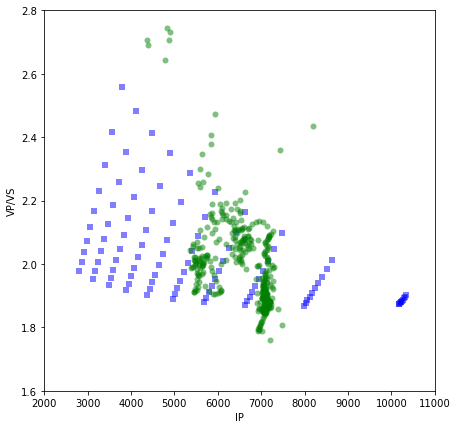

In [25]:
# New parameters.
RHO_sh=2.8;   K_sh=21;  MU_sh=3

ip_rpt0a, vpvs_rpt0a = rpt(model='soft',vsh=0.0,fluid='oil',phic=0.5,Cn=12,P=45,f=.3,display=False)
ip_rpt0b, vpvs_rpt0b = rpt(model='soft',vsh=0.6,fluid='oil',phic=0.5,Cn=12,P=45,f=.3,display=False)

f, ax = plt.subplots(figsize=(7,7))
#ax.plot(ip_rpt0a, vpvs_rpt0a, 'sk', mew=0, alpha=0.5)
ax.plot(ip_rpt0b, vpvs_rpt0b, 'sb', mew=0, alpha=0.5)
ax.plot(L.VP[ss]*L.RHO[ss], L.VP[ss]/L.VS[ss], **sty1)
ax.set_xlim(2e3,11e3), ax.set_ylim(1.6,2.8)

ax.set_xlabel('IP')
ax.set_ylabel('VP/VS')

# plt.savefig('/Users/matt/Dropbox/Agile/SEG/Tutorials/delMonte_Apr2017/Figure_3_part3.png', dpi=300)
plt.show()

## seismic modeling

Once I have a good grasp of the RPM, its adaptability to the situation under analysis, the way it reacts to different input parameters, I can start using it also to explore seismic data.

It is very easy to use the velocities and densities output by the function `vels` introduced earlier to build simple two-layer models and analyse seismic and AVO signatures of the modeled top reservoir.

In [26]:
def twolayer(vp0,vs0,rho0,vp1,vs1,rho1):
    from bruges.reflection import shuey2      # TODO:  install bruges.reflection
    from bruges.filters import ricker         # TODO:  install bruges.filters

    n_samples = 500
    interface=int(n_samples/2)
    ang=np.arange(31)
    wavelet=ricker(.25, 0.001, 25)

    model_ip,model_vpvs,rc0,rc1 = ( np.zeros(n_samples) for _ in range(4) )
    model_z = np.arange(n_samples)
    model_ip[:interface]=vp0*rho0
    model_ip[interface:]=vp1*rho1
    model_vpvs[:interface]=np.true_divide(vp0,vs0)
    model_vpvs[interface:]=np.true_divide(vp1,vs1)

    avo=shuey2(vp0,vs0,rho0,vp1,vs1,rho1,ang)
    rc0[interface]=avo[0]
    rc1[interface]=avo[-1]
    synt0=np.convolve(rc0,wavelet,mode='same')
    synt1=np.convolve(rc1,wavelet,mode='same')
    clip=np.max(np.abs([synt0, synt1]))
    clip += clip*.2
    
    opz0={'color':'b', 'linewidth':4}
    opz1={'color':'k', 'linewidth':2}
    opz2={'linewidth':0, 'alpha':0.5}

    f = plt.subplots(figsize=(10, 4))
    ax0 = plt.subplot2grid((1,16), (0,0), colspan=2) # ip
    ax1 = plt.subplot2grid((1,16), (0,2), colspan=2) # vp/vs
    ax2 = plt.subplot2grid((1,16), (0,4), colspan=2) # synthetic @ 0 deg
    ax3 = plt.subplot2grid((1,16), (0,6), colspan=2) # synthetic @ 30 deg
    ax4 = plt.subplot2grid((1,16), (0,9), colspan=7) # avo curve

    ax0.plot(model_ip, model_z, **opz0)
    ax0.set_xlabel('IP')
    ax0.locator_params(axis='x', nbins=2)

    ax1.plot(model_vpvs, model_z, **opz0)
    ax1.set_xlabel('VP/VS')
    ax1.locator_params(axis='x', nbins=2)

    ax2.plot(synt0, model_z, **opz1)
    ax2.fill_betweenx(model_z, 0, synt0, where=synt0>0, facecolor='black', **opz2)
    ax2.set_xlim(-clip,clip)
    ax2.set_xlabel('angle={:.0f}'.format(ang[0]))
    ax2.locator_params(axis='x', nbins=2)

    ax3.plot(synt1, model_z, **opz1)
    ax3.fill_betweenx(model_z, 0, synt1, where=synt1>0, facecolor='black', **opz2)
    ax3.set_xlim(-clip,clip)
    ax3.set_xlabel('angle={:.0f}'.format(ang[-1]))
    ax3.locator_params(axis='x', nbins=2)

    ax4.plot(ang, avo, **opz0)
    ax4.axhline(0, color='k', lw=2)
    ax4.set_xlabel('angle of incidence')
    ax4.tick_params(which='major', labelsize=8)

    for aa in [ax0,ax1,ax2,ax3]:
        aa.set_ylim(350,150)
        aa.tick_params(which='major', labelsize=8)
        aa.set_yticklabels([])

    plt.subplots_adjust(wspace=.8,left=0.05,right=0.95)

Let's start from the base scenario, i.e. the one observed on the real well. Average elastic properties from two fairly regular intervals above and below top reservoir can be extracted in this way:

In [27]:
top=2175
z0=top-40
z1=top
z2=top+40
z=L.index
ss = (z>=z1) & (z<=z2)
sh = (z>=z0) & (z<=z1)

vp0, vs0, rho0 = L[['VP','VS','RHO']][sh].mean().values
vp1, vs1, rho1 = L[['VP','VS','RHO']][ss].mean().values
samples_sh=np.isfinite(L.index[sh]).size
samples_ss=np.isfinite(L.index[ss]).size

print('({:>4.0f}-{:<4.0f}m,{:3d} samples) Vp={:.0f}, Vs={:.0f}, rho={:.2f}, Ip={:.0f}, Vp/Vs={:.2f} '.format(z0,z1,samples_sh,vp0,vs0,rho0,vp0*rho0,vp0/vs0))
print('({:>4.0f}-{:<4.0f}m,{:3d} samples) Vp={:.0f}, Vs={:.0f}, rho={:.2f}, Ip={:.0f}, Vp/Vs={:.2f} '.format(z1,z2,samples_ss,vp1,vs1,rho1,vp1*rho1,vp1/vs1))

(2135-2175m,262 samples) Vp=2430, Vs=919, rho=2.11, Ip=5136, Vp/Vs=2.64 
(2175-2215m,263 samples) Vp=3032, Vs=1543, rho=2.17, Ip=6593, Vp/Vs=1.96 


Then I will use `twolayer` to display seismic signatures at Near and Far offset traces and AVO curve:

C:\Users\tkngu\Dropbox\Work\RockPhysics\tutorials-2017\1706_Seismic_rock_physics\bruges\filters\wavelets.py:204: FutureWarning: In future releases, return_t will be True by default.
  warnings.warn("In future releases, return_t will be True by default.", FutureWarning)


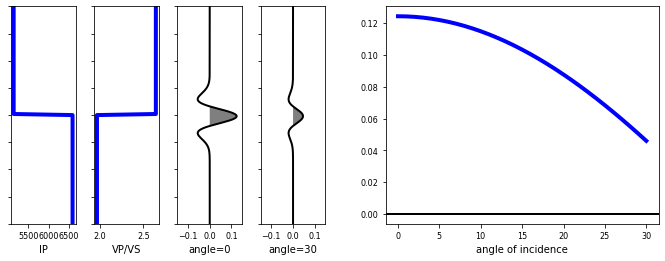

In [28]:
twolayer(vp0, vs0, rho0, vp1, vs1, rho1)

Using the RPM calibrated at the well, I can investigate different scenarios, e.g. by choosing a different fluid type:

C:\Users\tkngu\Dropbox\Work\RockPhysics\tutorials-2017\1706_Seismic_rock_physics\bruges\filters\wavelets.py:204: FutureWarning: In future releases, return_t will be True by default.
  warnings.warn("In future releases, return_t will be True by default.", FutureWarning)


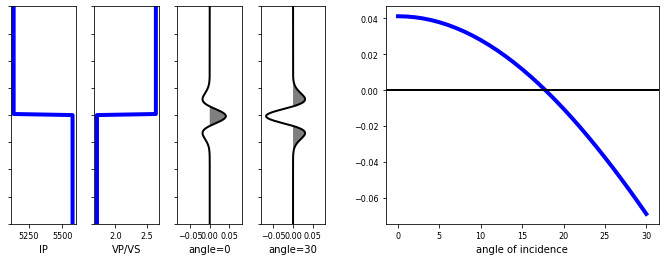

In [29]:
RHO_qz=2.65;   K_qz=37;  MU_qz=15
RHO_sh=2.8;   K_sh=15;  MU_sh=5

phi,nn=.15,.9
_,_,K0 = vrh(nn,K_qz,K_sh)
_,_,MU0 = vrh(nn,MU_qz,MU_sh)    
RHO0 = nn*RHO_qz+(1-nn)*RHO_sh

Kdry, MUdry = softsand(K0, MU0, phi, phic=.5, Cn=12, P=45,f=.3)
vp_rpm,vs_rpm,rho_rpm,_= vels(Kdry,MUdry,K0,RHO0,K_g,RHO_g,phi)

twolayer(vp0, vs0, rho0, vp_rpm, vs_rpm, rho_rpm)
#plt.title('GAS case, phi=0.15')

# plt.savefig('/Users/matt/Dropbox/Agile/SEG/Tutorials/delMonte_Apr2017/Figure_4.png', dpi=300)
plt.show()

Or increase the porosity:

C:\Users\tkngu\Dropbox\Work\RockPhysics\tutorials-2017\1706_Seismic_rock_physics\bruges\filters\wavelets.py:204: FutureWarning: In future releases, return_t will be True by default.
  warnings.warn("In future releases, return_t will be True by default.", FutureWarning)


Text(0.5, 1.0, 'GAS case, phi=0.25')

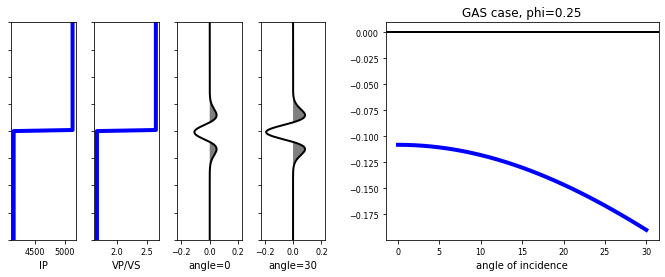

In [30]:
phi,nn=.25,.9
_,_,K0 = vrh(nn,K_qz,K_sh)
_,_,MU0 = vrh(nn,MU_qz,MU_sh)    
RHO0 = nn*RHO_qz+(1-nn)*RHO_sh

Kdry, MUdry = softsand(K0, MU0, phi, phic=.5, Cn=12, P=45,f=.3)
vp_rpm,vs_rpm,rho_rpm,_= vels(Kdry,MUdry,K0,RHO0,K_g,RHO_g,phi)

twolayer(vp0,vs0,rho0,vp_rpm,vs_rpm,rho_rpm)
plt.title('GAS case, phi=0.25')

## conclusions

I have shown here how to implement rock physics models and templates using standard Python libraries. The functions introduced here can be extended fairly easily for additional rock physics models (in the Appendix below I have included functions to calculate two other models). These functions form the basic building blocks of a workflow that can be used to study real datasets, analyse the elastic behaviour of individual reservoirs and build a collection of seismic and AVO signatures to be associated to particular associations of caprocks and reservoirs.

I should add that I have not made a particular effort to accurately describe the real dataset used here, and the entire set of parameters and result are not meant to represent the solution to this problem. If the reader wants to know more about this particular dataset, I would recommend the referenced articles and book by Per Avseth.

# appendix

Where I define two additional functions to code the Critical Porosity (Nur et al., 1991, 1995) and the Cemented Sand (or contact cement model; Dvorkin and Nur, 1996)
RPMs.

In [31]:
def critpor(K0, G0, phi, phic=0.4):
    '''
    Critical porosity, Nur et al. (1991, 1995)
    written by aadm (2015) from Rock Physics Handbook, p.353

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    '''
    K_DRY  = K0 * (1-phi/phic)
    G_DRY  = G0 * (1-phi/phic)
    return K_DRY, G_DRY

def contactcement(K0, G0, phi, phic=0.4, Cn=8.6, Kc=37, Gc=45, scheme=2):
    '''
    Contact cement (cemented sand) model, Dvorkin-Nur (1996)
    written by aadm (2015) from Rock Physics Handbook, p.255

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    Kc, Gc: cement bulk & shear modulus in GPa
            (default 37, 45 i.e. quartz)
    scheme: 1=cement deposited at grain contacts
            2=uniform layer around grains (default)
    '''
    PR0=(3*K0-2*G0)/(6*K0+2*G0)
    PRc = (3*Kc-2*Gc)/(6*Kc+2*Gc)
    if scheme == 1: # scheme 1: cement deposited at grain contacts
        alpha = ((phic-phi)/(3*Cn*(1-phic))) ** (1/4)
    else: # scheme 2: cement evenly deposited on grain surface
        alpha = ((2*(phic-phi))/(3*(1-phic)))**(1/2)
    LambdaN = (2*Gc*(1-PR0)*(1-PRc)) / (np.pi*G0*(1-2*PRc))
    N1 = -0.024153*LambdaN**-1.3646
    N2 = 0.20405*LambdaN**-0.89008
    N3 = 0.00024649*LambdaN**-1.9864
    Sn = N1*alpha**2 + N2*alpha + N3
    LambdaT = Gc/(np.pi*G0)
    T1 = -10**-2*(2.26*PR0**2+2.07*PR0+2.3)*LambdaT**(0.079*PR0**2+0.1754*PR0-1.342)
    T2 = (0.0573*PR0**2+0.0937*PR0+0.202)*LambdaT**(0.0274*PR0**2+0.0529*PR0-0.8765)
    T3 = 10**-4*(9.654*PR0**2+4.945*PR0+3.1)*LambdaT**(0.01867*PR0**2+0.4011*PR0-1.8186)
    St = T1*alpha**2 + T2*alpha + T3
    K_DRY = 1/6*Cn*(1-phic)*(Kc+(4/3)*Gc)*Sn
    G_DRY = 3/5*K_DRY+3/20*Cn*(1-phic)*Gc*St
    return K_DRY, G_DRY

# references

* Avseth, P., Mukerji, T. & Mavko, G.: Quantitative Seismic Interpretation. (Cambridge University Press, 2005).

* Dvorkin, J., Gutierrez, M. and Grana, D.: Seismic Reflections of Rock Properties.  (Cambridge University Press, 2012?).

* Mavko, G., Mukerji, T. & Dvorkin, J.: The Rock Physics Handbook. (Cambridge University Press, 2009).